<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [5]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 21 15:53:15 2016

@author: agiovann
"""
from IPython.display import YouTubeVideo as yt
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
import cv2
try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')

try:
    if __IPYTHON__:
        print((1))
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass
#%%
import caiman as cm
import numpy as np
import os
import glob
import time
import pylab as pl
import psutil
import sys
from ipyparallel import Client
from skimage.external.tifffile import TiffFile
import scipy
#%%
from caiman.motion_correction import tile_and_correct, motion_correction_piecewise
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.components_evaluation import evaluate_components 
from caiman.utils.visualization import plot_contours, view_patches_bar
from caiman.base.rois import extract_binary_masks_blob
from caiman.utils.utils import download_demo


#%%
#m = cm.load('example_movies/demoMovie.tif')
#
#cm.concatenate([m.resize(1,1,.2),m.resize(1,1,.2)],axis =1).play(fr =20, gain = 3.,magnification =3)
#%% set parameters and create template by RIGID MOTION CORRECTION
params_movie = {'fname': 'example_movies/demoSue2x.tif',
                'niter_rig': 1,
                'max_shifts': (6, 6),  # maximum allow rigid shift
                'splits_rig': 56,  # for parallelization split the movies in  num_splits chuncks across time
                # if none all the splits are processed and the movie is saved
                'num_splits_to_process_rig': None,
                # intervals at which patches are laid out for motion correction
                'strides': (48, 48),
                # overlap between pathes (size of patch strides+overlaps)
                'overlaps': (24, 24),
                'splits_els': 56,  # for parallelization split the movies in  num_splits chuncks across time
                # if none all the splits are processed and the movie is saved
                'num_splits_to_process_els': [28, None],
                'upsample_factor_grid': 4,  # upsample factor to avoid smearing when merging patches
                # maximum deviation allowed for patch with respect to rigid
                # shift
                'max_deviation_rigid': 3,
                'p': 1,  # order of the autoregressive system
                'merge_thresh': 0.8,  # merging threshold, max correlation allowed
                'rf': 15,  # half-size of the patches in pixels. rf=25, patches are 50x50
                'stride_cnmf': 6,  # amounpl.it of overlap between the patches in pixels
                'K': 4,  # number of components per patch
                # if dendritic. In this case you need to set init_method to
                # sparse_nmf
                'is_dendrites': False,
                'init_method': 'greedy_roi',
                'gSig': [4, 4],  # expected half size of neurons
                'alpha_snmf': None,  # this controls sparsity
                'final_frate': 30
                }

1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#%% parameters from dictionary
fname = params_movie['fname']
niter_rig = params_movie['niter_rig']
# maximum allow rigid shift
max_shifts = params_movie['max_shifts']  
# for parallelization split the movies in  num_splits chuncks across time
splits_rig = params_movie['splits_rig']  
# if none all the splits are processed and the movie is saved
num_splits_to_process_rig = params_movie['num_splits_to_process_rig']
# intervals at which patches are laid out for motion correction
strides = params_movie['strides']
# overlap between pathes (size of patch strides+overlaps)
overlaps = params_movie['overlaps']
# for parallelization split the movies in  num_splits chuncks across time
splits_els = params_movie['splits_els'] 
# if none all the splits are processed and the movie is saved
num_splits_to_process_els = params_movie['num_splits_to_process_els']
# upsample factor to avoid smearing when merging patches
upsample_factor_grid = params_movie['upsample_factor_grid'] 
# maximum deviation allowed for patch with respect to rigid
# shift
max_deviation_rigid = params_movie['max_deviation_rigid']

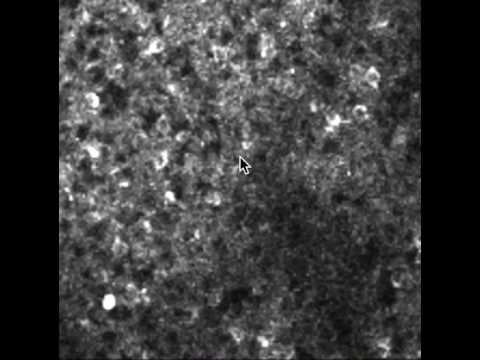

In [7]:
#%% download movie if not there
if fname == 'example_movies/demoSue2x.tif':
    download_demo()
yt("I1yc8LLwI-8")

In [9]:
#%% load movie (in memory!)
m_orig = cm.load(fname)
#%% play movie
downsample_ratio = .2
offset_mov = -np.min(m_orig[:100])
m_orig.resize(1, 1, downsample_ratio).play(
    gain=10, offset = offset_mov, fr=30, magnification=2)

reshaping along z


<em>some of the pixels in this movie are negative, we then need to make them positive </em>

<h2> As we can see here there is a parralelization process in the motioncorrect class </h2>
<p> this class will do create temporal chunks of the movie for it to be treated in parallel on all the core of the computer. </p>
<p> It uses ipyparrallel to parallelize the python ( see : https://ipyparallel.readthedocs.io/en/latest/intro.html) and slurm to manage the workload ( see : https://slurm.schedmd.com/quickstart.html ) </p>
<p><img src="docs/img/cordermmap.png" /> </p>

In [10]:
#%% motion correction rigid
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

using 4 processes
C was not existing, creating one
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
Waiting for cluster to stop....... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......Using 4 processes


<h1> we are now entering the process of rigid correction</h1>
<p>wich will be based on the correlation to a template image. A correction will be find for each image as a displacement vector. this template image (usually the median of each image over time) will be updated each time that the movie is corrected to increase its precision </p>
<img src="dev/kalfon/img/rigidcorrection.png" />
more info : <em> http://opencv.org/about.html </em>


Rigid Motion Correction
296.0
-296.0
Frame 100


caiman/base/movies.py:235: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  warnings.warn('** Pixels averages are too negative. Removing 1 percentile. **')
caiman/base/movies.py:253: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  warnings.warn('Pixels averages are too negative for template. Removing 1 percentile.')


Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-296.0
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-296.0
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Adding to movie 296.0
0
saving!
43.7499568462


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in float_scalars
  return a / b


nan
mmap
reshaping along z


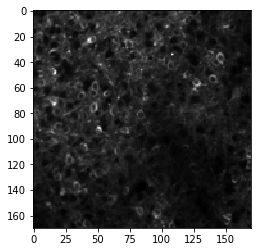

In [11]:
# movie must be mostly positive for this to work
min_mov = cm.load(fname, subindices=range(400)).min()

mc = MotionCorrect(fname, min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig, splits_rig=splits_rig, 
                   num_splits_to_process_rig=num_splits_to_process_rig, 
                strides= strides, overlaps= overlaps, splits_els=splits_els,
                num_splits_to_process_els=num_splits_to_process_els, 
                upsample_factor_grid=upsample_factor_grid, max_deviation_rigid=max_deviation_rigid, 
      
                shifts_opencv = True, nonneg_movie = True)
#%%
mc.motion_correct_rigid(save_movie=True)
# load motion corrected movie
m_rig = cm.load(mc.fname_tot_rig)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)
#%% visualize templates
pl.imshow(mc.total_template_rig, cmap = 'gray')
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    gain=10, offset = offset_mov*.25, fr=30, magnification=2,bord_px = bord_px_rig)

<h2> have a look at the motion correction </h2>

In [ ]:
#%% plot rigid shifts
pl.close()
pl.plot(mc.shifts_rig)
pl.legend(['x shifts','y shifts'])
pl.xlabel('frames')
pl.ylabel('pixels')

<h1> Piece-Wise rigid motion correction </h1>
<p> used to do a non rigid motion correction in a fashion that has the same linear usage of computing power as a rigid motion correction <p>
<img src="docs\img\pwrigidcorrection.png" />
<p> more info : </p>
<em> http://biorxiv.org/content/biorxiv/early/2017/02/14/108514.full.pdf </em>

Adding to movie 296.0
0
saving mmap of example_movies/demoSue2x.tif
**** MOVIE NOT SAVED BECAUSE num_splits is not None ****
123.657406807
Adding to movie 296.0
0
saving mmap of example_movies/demoSue2x.tif
189.947425127
mmap


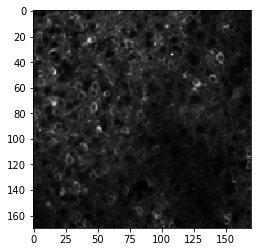

In [11]:
#%% motion correct piecewise rigid
mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig, show_template = True)
m_els = cm.load(mc.fname_tot_els)
pl.imshow(mc.total_template_els, cmap = 'gray')

In [ ]:
#%% visualize elastic shifts
pl.close()
pl.subplot(2, 1, 1)
pl.plot(mc.x_shifts_els)
pl.ylabel('x shifts (pixels)')
pl.subplot(2, 1, 2)
pl.plot(mc.y_shifts_els)
pl.ylabel('y_shifts (pixels)')
pl.xlabel('frames')
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

In [ ]:
# check movie
downsample_ratio = .2
m_els.resize(1, 1, downsample_ratio).play(
    gain=10, offset = 0, fr=30, magnification=2,bord_px = bord_px_els)
# compare with original and rigid corrected movies
downsample_factor = .2
cm.concatenate([m_orig.resize(1, 1, downsample_factor)+offset_mov, m_rig.resize(1, 1, downsample_factor), m_els.resize(
    1, 1, downsample_factor)], axis=2).play(fr=60, gain=15, magnification=2, offset=0)
#%% local correlation
pl.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

<h1> Assessing Motion correction Quality </h1>
for the raw, rigid corrected and piecewise rigid corrected videos
<p> using smoothness <em> (mean over time) </em> </p>
--------------
<p> using correlation to the template <em> (Pearson Correlation coefficient)</em> </p> 
--------------
see : http://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/template_matching/template_matching.html ( like a normalized SSD )
<p> optical flow : </p>
--------------
<img src="docs/img/opticalflow.png" />
more info :<em> http://docs.opencv.org/trunk/d7/d8b/tutorial_py_lucas_kanade.html </em>

In [ ]:
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els)
winsize = 100
swap_dim = False
resize_fact_flow = .2
tmpl, correlations, flows_orig, norms, smoothness = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els, final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)
tmpl, correlations, flows_orig, norms, smoothness = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig, final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)
tmpl, correlations, flows_orig, norms, smoothness = cm.motion_correction.compute_metrics_motion_correction(
    fname, final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

In [4]:
#%% plot the results of metrics
fls = [mc.fname_tot_els[:-4] + '_metrics.npz', mc.fname_tot_rig[:-4] +
       '_metrics.npz', mc.fname[:-4] + '_metrics.npz']
#%%
for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
#        pl.figure()
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        pl.subplot(len(fls), 4, 1 + 4 * cnt)
        pl.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        pl.imshow(mean_img, vmin=lq, vmax=hq)
        pl.title('Mean')
        #        pl.plot(ld['correlations'])

        pl.subplot(len(fls), 4, 4 * cnt + 2)
        pl.imshow(ld['img_corr'], vmin=0, vmax=.35)
        pl.title('Corr image')
    #        pl.colorbar()
        pl.subplot(len(fls), 4, 4 * cnt + 3)
    #
        pl.plot(ld['norms'])
        pl.xlabel('frame')
        pl.ylabel('norm opt flow')
        pl.subplot(len(fls), 4, 4 * cnt + 4)
        flows = ld['flows']
        pl.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        pl.colorbar()
        pl.title('Mean optical flow')
            

NameError: name 'mc' is not defined

<h1> Memory mapping </h1>
<p>needed to have a much faster and parallel computation of subset of the movie. creating spatial chunks of the movie to compute in parallel over time threw this chunks. accessing in memory chains of the same pixels through time.</p>
<p><img src="docs/img/fordermmap.png" /></p>
<h3> As you can see, there is already chunks of the movie but in the temporal order for the previous paralellization.</h3>
<p> we are getting subchunks of the movie in the F order ( see https://en.wikipedia.org/wiki/Row-_and_column-major_order ) those subchunks are then glued together in the temporal axis ( F order ) to create spatial chunks of the entire movie that will get treated by the CNMF )
</p>

In [2]:
# MEMORY MAPPING: save each chunk in F format on memory mapped files
if not params_movie.has_key('max_shifts'):
    fnames = [params_movie['fname']]
    border_to_0 = 0
elif not params_movie.has_key('overlaps'):
    fnames = [mc.fname_tot_rig]
    border_to_0 = bord_px_rig
    m_els = m_rig
else:
    fnames = [mc.fname_tot_]
    border_to_0 = bord_px_els
    
# if you need to crop the borders use slicing    
# idx_x=slice(border_nan,-border_nan,None)
# idx_y=slice(border_nan,-border_nan,None)
# idx_xy=(idx_x,idx_y)
idx_xy = None
add_to_movie = -np.nanmin(m_els) + 1  # movie must be positive
# if you need to remove frames from the beginning of each file
remove_init = 0
# downsample movie in time: use .2 or .1 if file is large and you want a quick answer             
downsample_factor = 1 
base_name = fname.split('/')[-1][:-4]
name_new = cm.save_memmap_each(fnames, dview=dview, base_name=base_name, resize_fact=(
    1, 1, downsample_factor), remove_init=remove_init, idx_xy=idx_xy, add_to_movie=add_to_movie, border_to_0=border_to_0)
name_new.sort()
print(name_new)

#%% concatenate chunks if needed
if len(name_new) > 1:
    fname_new = cm.save_memmap_join(
        name_new, base_name='Yr', n_chunks=12, dview=dview)
else:
    print('One file only, not saving!')
    fname_new = name_new[0]

NameError: name 'params_movie' is not defined

In [8]:
#%% LOAD MEMMAP FILE
# fname_new='Yr_d1_501_d2_398_d3_1_order_F_frames_369_.mmap'
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F')
Y = np.reshape(Yr, dims + (T,), order='F')
m_images = cm.movie(images)
#%%  checks on movies (might take time if large!)
if np.min(images) < 0:
    raise Exception('Movie too negative, add_to_movie should be larger')
if np.sum(np.isnan(images)) > 0:
    raise Exception('Movie contains nan! You did not remove enough borders')
#%% correlation image
Cn = cm.local_correlations(Y)
Cn[np.isnan(Cn)] = 0
pl.imshow(Cn, cmap='gray', vmax=.35)
#%% some parameter settings
# order of the autoregressive fit to calcium imaging in general one (slow gcamps) or two (fast gcamps fast scanning)
p = params_movie['p']  
# merging threshold, max correlation allowed
merge_thresh= params_movie['merge_thresh'] 
# half-size of the patches in pixels. rf=25, patches are 50x50
rf = params_movie['rf']  
# amounpl.it of overlap between the patches in pixels
stride_cnmf = params_movie['stride_cnmf'] 
 # number of components per patch
K =  params_movie['K'] 
# if dendritic. In this case you need to set init_method to sparse_nmf
is_dendrites = params_movie['is_dendrites']
# iinit method can be greedy_roi for round shapes or sparse_nmf for denritic data
init_method = params_movie['init_method']
# expected half size of neurons
gSig = params_movie['gSig']  
# this controls sparsity
alpha_snmf = params_movie['alpha_snmf']  
#frame rate of movie (even considering eventual downsampling)
final_frate = params_movie['final_frate']

NameError: name 'fname_new' is not defined

<h1> CNMF on patches </h1>
<p> where we will Extract spatial and temporal components on patches </p>

More information here : <em> http://www.cell.com/neuron/fulltext/S0896-6273(15)01084-3?_returnURL=http%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0896627315010843%3Fshowall%3Dtrue </em>

<p> <img src="docs/img/cnmf1.png" /> </p>

<p> A merging step is added to merge all the same neurons that have been identified by different cnmf on different chunks <p>
<em> this is done by comparing the temporal activity of neurons which have more than a certain amount of shared space </em>


In [ ]:
if params_movie['is_dendrites'] == True:
    if params_movie['init_method'] is not 'sparse_nmf':
        raise Exception('dendritic requires sparse_nmf')
    if params_movie['alpha_snmf'] is None:
        raise Exception('need to set a value for alpha_snmf')
#%% Extract spatial and temporal components on patches
t1 = time.time()
cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=0, dview=dview, Ain=None, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, method_deconvolution='oasis')
cnm = cnm.fit(images)

A_tot = cnm.A
C_tot = cnm.C
YrA_tot = cnm.YrA
b_tot = cnm.b
f_tot = cnm.f
sn_tot = cnm.sn
t2 = time.time() - t1
print(('Number of components:' + str(A_tot.shape[-1])))
#%%
pl.figure()
crd = plot_contours(A_tot, Cn, thr=0.9)

<h1>DISCARD LOW QUALITY COMPONENT </h1>
<p> important step because too many neurons have being sleected and are false. </p>
<p> done by ranking the components according to the probability of a spike given the noise </p>
<img src="docs/img/evaluationcomponent.png"/>
<p> done in steps :</p>
<ul><li> Calculating the mode ( most present value )</li>
<li> get the values under the mode (noise )</li>
<li> get the dispertion (std of noise) </li>
<li> compute the probability of having events given the noise distribution we have </li>
<li><b> we put a threshold on this probability s.t. some of the component are discarded</b> </li>
<li> we also proceed to what is described under "spatial" in the image</li>


In [ ]:
#%% DISCARD LOW QUALITY COMPONENT
from caiman.components_evaluation import estimate_components_quality
final_frate = params_movie['final_frate']
r_values_min = .7  # threshold on space consistency
fitness_min = -40  # threshold on time variability
# threshold on time variability (if nonsparse activity)
fitness_delta_min = -40
Npeaks = 10
traces = C_tot + YrA_tot
idx_components, idx_components_bad = estimate_components_quality(
    traces, Y, A_tot, C_tot, b_tot, f_tot, final_frate=final_frate, Npeaks=Npeaks, r_values_min=r_values_min, fitness_min=fitness_min, fitness_delta_min=fitness_delta_min)
print(('Keeping ' + str(len(idx_components)) +
       ' and discarding  ' + str(len(idx_components_bad))))
#%%
pl.figure()
crd = plot_contours(A_tot.tocsc()[:, idx_components], Cn, thr=0.9)

<h1> CNMF full frame </h1> 

In [ ]:
#%%
A_tot = A_tot.tocsc()[:, idx_components]
C_tot = C_tot[idx_components]
#%% rerun updating the components to refine
cnm = cnmf.CNMF(n_processes, k=A_tot.shape, gSig=gSig, merge_thresh=merge_thresh, p=p, dview=dview, Ain=A_tot, Cin=C_tot,
                f_in=f_tot, rf=None, stride=None, method_deconvolution='oasis')
cnm = cnm.fit(images)
#%%
A, C, b, f, YrA, sn = cnm.A, cnm.C, cnm.b, cnm.f, cnm.YrA, cnm.sn

<h1> Discard low quality components on full frame</h1>


In [ ]:
#%% again recheck quality of components, stricter criteria
final_frate = params_movie['final_frate']
r_values_min = .75
fitness_min = - 50
fitness_delta_min = - 50
Npeaks = 10
traces = C + YrA
idx_components, idx_components_bad = estimate_components_quality(
    traces, Y, A, C, b, f, final_frate=final_frate, Npeaks=Npeaks, r_values_min=r_values_min, fitness_min=fitness_min, fitness_delta_min=fitness_delta_min)
print(' ***** ')
print((len(traces)))
print((len(idx_components)))

In [ ]:
#%% visualize included and excluded components
pl.subplot(1, 2, 1)
crd = plot_contours(A.tocsc()[:, idx_components], Cn, thr=0.9)
pl.subplot(1, 2, 2)
crd = plot_contours(A.tocsc()[:, idx_components_bad], Cn, thr=0.9)

In [ ]:
#%% visualize spatial and temporal components
view_patches_bar(Yr, scipy.sparse.coo_matrix(A.tocsc()[:, idx_components]), C[
    idx_components, :], b, f, dims[0], dims[1], YrA=YrA[idx_components, :], img=Cn)
#%%
view_patches_bar(Yr, scipy.sparse.coo_matrix(A.tocsc()[:, idx_components_bad]), C[
    idx_components_bad, :], b, f, dims[0], dims[1], YrA=YrA[idx_components_bad, :], img=Cn)

<h1> closing, saving, and creating denoised version </h1>

In [ ]:
#%% save results
np.savez(os.path.join(os.path.split(fname_new)[0], os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'), Cn=Cn, A=A.todense(
), C=C, b=b, f=f, YrA=YrA, sn=sn, d1=d1, d2=d2, idx_components=idx_components, idx_components_bad=idx_components_bad)

In [ ]:
#%% STOP CLUSTER and clean up log files
cm.stop_server()
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

In [ ]:
    
#%% reconstruct denoised movie
denoised = cm.movie(A.dot(C) + b.dot(f)).reshape(dims+(-1,),order = 'F').transpose([2,0,1])
#%% 
denoised.play(gain = 10, offset = 0,fr =100, magnification = 2)

In [ ]:
#%% reconstruct denoised movie without background
denoised = cm.movie(A.dot(C)).reshape(dims+(-1,),order = 'F').transpose([2,0,1])
#%%
denoised.play(gain = 30, offset = 0,fr =100, magnification = 2)